# Проект: вариант 2
## Задание 1. A/B–тестирование
### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)
groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.
checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента.
### 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

### 1.4 Требования к ответу

При выполнении тестового задания необходимо использовать язык программирования Python.
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными.
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pylab
from tqdm.auto import tqdm
from scipy.stats import norm
import numpy as np

## Обработка и проверка данных

### *Groups - данные о принадлежности пользователей к контрольной (А) и целевой (B) группам*

In [2]:
groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/58Us0DWOzuWAjg', sep=';')

In [3]:
groups.head()  # посмотрим данные

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups.isna().sum()  # проверим есть ли пропущенные значения

id     0
grp    0
dtype: int64

пропущенных значений нет

In [5]:
groups.id.nunique() == groups.shape[0]  # проверим уникальны ли id в таблице

True

повторяющихся значений в таблице нет, можно также сделать вывод, что пользователи были разделены корректно - каждый пользоватль принадлежит только одной группе

In [6]:
groups.groupby('grp').id.count()  # количество пользователей в контрольной (А) и целевой (B) группах

grp
A    14671
B    59813
Name: id, dtype: int64

отметим что в целевой группе "B" гораздо больше пользователей чем в контрольной "А"

### *Groups_add - дополнительные данные о принадлежности пользователей*

In [7]:
group_add = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/3aARY-P9pfaksg', sep=',')

In [8]:
group_add.head()  # поглядим на данные вцелом

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [9]:
group_add.isna().sum()  # проверим есть ли пропущенные значения

id     0
grp    0
dtype: int64

пропущенных значений нет

In [10]:
group_add.id.nunique() == group_add.shape[0]  # проверим уникальны ли id в таблице

True

повторяющихся значений в таблице нет, можно также сделать вывод, что пользователи были разделены верно - каждый пользоватль принадлежит только одной группе

In [11]:
group_add.groupby('grp').id.count()  # количество пользователей в контрольной и целевой группах в дополнительных данных

grp
A    22
B    70
Name: id, dtype: int64

опять же отметим что в целевой "B" группе пользователей больше и в дополнительных данных

### *checks - данные об оплатах пользователей в дни проведения эксперемента*

In [12]:
checks = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/84hTmELphW2sqQ', sep=';')

In [13]:
checks.head()  # глянем

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [14]:
checks.isna().sum()  # проверим есть ли пропущенные значения

student_id    0
rev           0
dtype: int64

пропущенных значений нет

In [15]:
checks.student_id.nunique() == checks.shape[0]  # проверим уникальность student_id

True

в student_id нет повторяющихся значений следовательно на каждого пользоватля в таблице приходится один чек (или сумма чеков)

### *active_studs - данные о пользователях зашедших на платформу в дни эксперимента*

In [16]:
active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/prbgU-rZpiXVYg', sep=';')

In [17]:
active_studs.head()  # смотрим

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [18]:
active_studs.isna().sum()  # проверим есть ли пропущенные значения

student_id    0
dtype: int64

пропущенных значений нет

### *Объединим таблицы с данными в одну результирующую*

In [19]:
df = groups.append(group_add)  # добавим к таблице groups таблицу group_add

In [20]:
df.shape[0] == groups.shape[0] + group_add.shape[0]  # проверим верно ли произошло объединение

True

количество строк совпадает

In [21]:
experiment = df.merge(active_studs, how='outer', left_on='id', right_on='student_id')  
# смёрджим датафрейм где пользователи разбиты по группам (df) с датафреймом активных пользователей active_studs.

столбец student_id дублирует столбец id. Заменим значения в столбце student_id в зависимости от значения: пропущенные значения заменим на False заполненные значения на True. Так как столбец student_id пришёл из датафрейма активных пользователей, то преобразованный таким образом столбец будет отображать был ли данный пользователь активен во время эскперимента или нет. Переименуем данный столбец в active

In [22]:
experiment['student_id'] = experiment.student_id.notna()
experiment.rename(columns={'student_id': 'active'}, inplace=True)

In [23]:
experiment = experiment.merge(checks, how='outer', left_on='id', right_on='student_id')  
# примерджим к получившемуся датафрейму experiment датафрейм checks с данными об оплате. Тип merge outer

столбец student_id преобразуем аналогичным образом как и в предыдущем шаге. Новый столбец отображает заплатил ли пользователь во время эксперимента. Назовём его payingю Заменим NaN в столбце rev на 0.

In [24]:
experiment['student_id'] = experiment.student_id.notna()
experiment.rename(columns={'student_id': 'paying'}, inplace=True)
experiment.rev.fillna(0, inplace=True)

In [25]:
experiment.head()

,id,grp,active,paying,rev
0,1489,B,False,False,0.0
1,1627,A,True,True,990.0
2,1768,B,False,False,0.0
3,1783,B,False,False,0.0
4,1794,A,False,False,0.0


### *Покрутим по всякому получившийся датафрейм*

In [26]:
experiment.groupby('grp').agg({'id': 'count'})  # посмотрим на количество пользователей в каждой группе

,id
grp,
A,14693
B,59883


В целевой группе "B" гораздо больше пользователей чем в контрольной.
Обычно когда тестируют гипотезу, новую функцию распространяют на меньшую часть пользователей продукта, чтобы избежать потерь и больших проблем, если новая функция не зайдет.
В нашем случае целевая группа может больше потому что была уверенность в успехе эсперимента, либо старая механика оплаты была очень плоха.

In [27]:
experiment.groupby(['grp', 'active', 'paying']).rev.sum()  # посмотрим суммы чеков

grp  active  paying
A    False   False          0.0000
             True       19276.0000
     True    False          0.0000
             True       72820.0000
B    False   False          0.0000
             True       86256.0001
     True    False          0.0000
             True      394974.0035
Name: rev, dtype: float64

На первый взгляд  выглядит странным что у пользователей которые не заходили на платформу были платежи в дни проведения эксперимента. Такое наблюдается в обоих группах в целевой и в контрольной

Расмотрим такие случаи

In [28]:
experiment.groupby(['grp', 'active', 'paying']).id.count()

grp  active  paying
A    False   False     13126
             True         29
     True    False      1460
             True         78
B    False   False     52960
             True        120
     True    False      6489
             True        314
Name: id, dtype: int64

In [29]:
experiment.query('paying == True').groupby(['grp', 'active']).id.count()

grp  active
A    False      29
     True       78
B    False     120
     True      314
Name: id, dtype: int64

около 30% платежей в каждой группе были от пользователей которые не заходили на платформу во время эксперимента.
Версии как такое могло произойти:
* пользователи совершили платеж не посещая сайт, воспользовавшись иными способами оплаты или автоплатежом
* что то пошло не так когда записывались данные эксперимента (данные о посещении)
* ошибка в данных о платежах


Не стоит исключать две последние версии, но тогда это ставит под вопрос все полученные в ходе эксперимента данные.

Предположим, что пользователи совершили платёж не посещая сайт воспользовавшись альтернативными способами оплаты. Значит следует оставить в датафрейме данные только о тех пользователях которые посещали платформу во время эксперимента и воспользовались обновленной механикой оплаты.

In [30]:
exp_active = experiment.query('active == True')  # создаём датафрейм с активными пользователями

In [31]:
exp_active.head()

,id,grp,active,paying,rev
1,1627,A,True,True,990.0
10,2085,B,True,False,0.0
12,2215,B,True,False,0.0
43,3391,A,True,False,0.0
45,3401,B,True,False,0.0


Конверсия в покупку в группах:

In [32]:
exp_active.groupby('grp').paying.mean()

grp
A    0.050715
B    0.046156
Name: paying, dtype: float64

Средний чек в группах

In [33]:
exp_active.query('paying == True').groupby('grp').rev.mean()

grp
A     933.589744
B    1257.878992
Name: rev, dtype: float64

Медианный чек в группах

In [34]:
exp_active.query('paying == True').groupby('grp').rev.median()

grp
A     585.0
B    1140.0
Name: rev, dtype: float64

### Метрики
Конверсия в покупку весьма важна в нашем эксперименте, т.к. если новая механика оплаты работает плохо или не нравится пользователям то эта метрика просядет.
Так же будем смотреть размер чека, т.к. в конце концов, его увеличение или, по крайней мере, сохранение является целью бизнеса.

Видим что средний больше в целевой группе, а конверсия в покупку больше в контрольной группе.

Проверим являются ли эти различия статически значимыми.

## *Потестируем!*

### *Для начала сравним конверсию в покупки в обеих группах.*

Для начала сравним конверсию в покупки в обеих группах.

Так как в данном случае мы имеем дело с номинативными переменными: A/B True/False(1/0) будем использовать один из тестов:
* chi-square test (неплохо подходит в данном случае)
* fisher exact test (хорош для маленьких выборок)
* proportion z test (не очень хорош когда размеры выборок отличаются)
* bootstrap (подходит нам, но требует больше времени на написание чем тот же chi-square test)
* и даже t-test (в данном случае всё же воспользоваться другими варинатами)

Выберем тест хи-квадрат (chi-square test), т.к. он подходит в данном случае.

* **Нулевая гипотеза (H0)** конверсия в покупку в двух группах стат. значимо не различается
* **Альтернативная гипотеза (H1)** конверсия в покупку в двух группах стат. значимо различается

Отвергать нулевую гипотезу будем при уровне p_value <= 0.05

In [35]:
co_table = pd.crosstab(exp_active['grp'], exp_active['paying'])  # построим таблицу сопряженности

In [36]:
co_table

paying,False,True
grp,,
A,1460,78
B,6489,314


In [37]:
stat, p_value, dof, expected = stats.chi2_contingency(co_table)  # проводим тест

In [38]:
p_value

0.48625240457231045

Полученный в результате теста p_value не позволяет отвергнуть нулевую гипотезу. Мы можем сделать вывод, что наш AB тест показал, что конверсия в покупку в целевой и контрольной группах не различается.

### *Cравним размер чеков в обеих группах*

Сначала следует определиться каким тестом будем пользоваться. По хорошему этим вопросом следует задаться ещё на этапе дизайна AB теста.

В данном случае нам предстоит сравнить две группы по одной метрике и нам подходит:
* t-test (критерий Стьюдента)
* mann-whitney u test (критерий Манна-Уитни)
* bootstrap

Требования к выборкам t-test (критерию стьюдента):
* Дисперсия внутри групп должны быть примерно одинаковы(требование гомогенности дисперсий).
* Распределение средних метрики должно быть нормальным.


In [39]:
exp_pay = exp_active.query('paying == True')  # передадим в новый датафрейм только оплативших пользователей

In [40]:
exp_pay.head()

,id,grp,active,paying,rev
1,1627,A,True,True,990.0000
220,100300,B,True,True,990.0000
320,108270,B,True,True,290.0000
3779,264473,B,True,True,1900.0001
4187,274352,B,True,True,690.0000


Построим пару графиков чтобы понять как распределены значения выборочных средних: нормально или нет.

Для этого объявим функцию которая будет брать выборки (с возвращением) из наших групп и считать для них среднее и строить Q-Q график и гистограмму распределения.
Так же впишем в функцию проверку полученных распределений выборочных средних **критерием Шапиро-Уилка** на нормальность
* **Нулевая гипотеза (H0)** выборки получены из нормального распределения
* **Альтернативная гипотеза (H1)** выборка получены не из нормального распределения

Отвергать нулевую гипотезу будем при уровне p_value < 0.05

In [41]:
def get_sample_aver(
        data_column_1,  # числовые значения первой выборки
        data_column_2,  # числовые значения второй выборки
        boot_it=1000,  # количество подвыборок
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data_1 = []
    boot_data_2 = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace=True  # параметр возвращения
        ).values

        samples_2 = data_column_2.sample(
            boot_len,
            replace=True
        ).values

        boot_data_1.append(np.mean(samples_1))
        boot_data_2.append(np.mean(samples_2))

    s1, p1 = stats.shapiro(boot_data_1)
    s2, p2 = stats.shapiro(boot_data_2)

    print(f'p value для группы А {p1}')
    print(f'p value для группы B {p2}')

    # визуализация
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    ax1 = plt.subplot(221)
    stats.probplot(boot_data_1, dist='norm', plot=plt)
    ax1.set_title("Распределение выборочных средних А")
    ax2 = plt.subplot(222)
    stats.probplot(boot_data_2, dist='norm', plot=plt)
    ax2.set_title("Распределение выборочных средних B")
    plt.subplot(223)
    sns.histplot(data=boot_data_1)
    plt.subplot(224)
    sns.histplot(data=boot_data_2)
    pylab.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

p value для группы А 0.29154568910598755
p value для группы B 0.2527162432670593


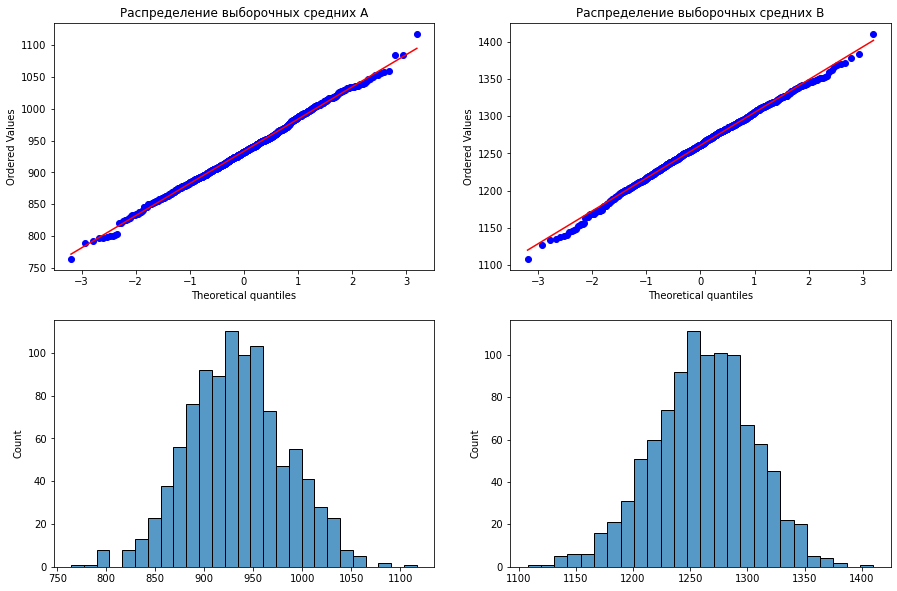

In [42]:
get_sample_aver(exp_pay[exp_pay.grp == 'A'].rev, exp_pay[exp_pay.grp == 'B'].rev)

По графикам видно что оба распредления довольно близки к нормальным. Проверка нормальности критерием Шапиро-Уилка в обоих группах показала p-value больше 0.05, что не позволяет нам отвергнуть нулевую гипотезу о нормальности выборок. Будем считать что выборки нормальны.

Проверим гомогенность дисперсий в группах помощью **критерия Левена**:
* **Нулевая гипотеза (H0)** дисперсия в выборках гомогенна
* **Альтернативная гипотеза (H1)** дисперсия в выборках не гомогенна

Отвергать нулевую гипотезу будем при уровне p_value < 0.05

In [43]:
stats.levene(exp_pay[exp_pay.grp == 'A'].rev, exp_pay[exp_pay.grp == 'B'].rev)

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)

Полученные pvalue = 0.08 не позволят нам отвергнуть нулевую гипотезу, а значит дисперссии в выборках гомогенны.

Требования критерия **t test Стьюдента** соблюдены.
А значит можно сравнить чеки в обоих группах:
* **Нулевая гипотеза (H0)** между средними значениями в обоих группах нет различия
* **Альтернативная гипотеза (H1)** средние значения в обоих группах не равны

Отвергать нулевую гипотезу будем при уровне p-value < 0.05


In [44]:
stats.ttest_ind(exp_pay[exp_pay.grp == 'A'].rev, exp_pay[exp_pay.grp == 'B'].rev)

Ttest_indResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867)

Полученные pvalue = 0.002 позволят нам отвергнуть нулевую гипотезу, а значит согласно t test Стьюдента средние чеки в группах стат. значимо различаются.

В данном случае также можно использовать **mann-whitney u test** и (или) **bootstrap**.

Используем **bootstrap** с оценкой среднего и медианы, чтобы избежать влияния выбросов на результаты.

* **Нулевая гипотеза (H0)** среднее/медиана чеков в двух группах стат. значимо равны
* **Альтернативная гипотеза (H1)** среднее/медиана чеков в двух группах стат. значимо различаются

Отвергать нулевую гипотезу будем при уровне p_value < 0.05

Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа


In [45]:
def get_bootstrap(
        data_column_1,  # числовые значения первой выборки
        data_column_2,  # числовые значения второй выборки
        boot_it=1000,  # количество бутстрэп-подвыборок
        statistic=np.mean,  # интересующая нас статистика
        bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace=True  # параметр возвращения
        ).values

        samples_2 = data_column_2.sample(
            boot_len,
            replace=True
        ).values

        boot_data.append(statistic(samples_1 - samples_2))  # mean() - применяем статистику

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x=0,
        loc=np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0,
        loc=-np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)

    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=100, colors='black', linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

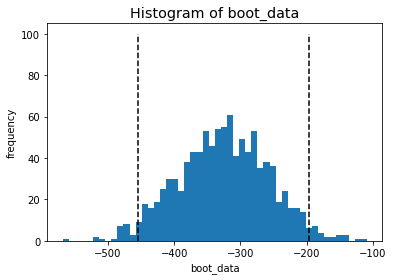

In [46]:
booted_data = get_bootstrap(exp_pay[exp_pay.grp == 'A'].rev, exp_pay[exp_pay.grp == 'B'].rev)

In [47]:
booted_data["p_value"]

1.9220090767460656e-06

  0%|          | 0/1000 [00:00<?, ?it/s]

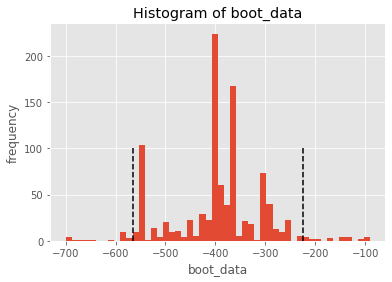

In [48]:
booted_data = get_bootstrap(exp_pay[exp_pay.grp == 'A'].rev, exp_pay[exp_pay.grp == 'B'].rev, statistic=np.median)

In [49]:
booted_data["p_value"]

1.6243464206412598e-05

В результате bootstrapa в обоих случаях получилили p_value значительно меньше 0.05, что позволяет нам отвергнуть нулевую гипотезу. По результатам теста можем сделать вывод что чеки в выборках стат. значимо различаются.

Проведем также  **Mann-whitney u test**, но следует учитывать что этот тест не очень хорош когда выборки отличаются по размеру. Это сказывается в первую очередь на мощности критерия – чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу (эффект).

* **Нулевая гипотеза (H0)** стат. значимых различий между распределением размера чека в выборкаx нет
* **Альтернативная гипотеза (H1)** распредление размера чека в выборках стат. значимо различаются.

Отвергать нулевую гипотезу будем при уровне p_value <= 0.05



In [50]:
U1, p = stats.mannwhitneyu(exp_pay[exp_pay.grp == 'A'].rev, exp_pay[exp_pay.grp == 'B'].rev)

In [51]:
p

0.0001255696915703461

Mann-whitney u test показал p_value меньше 0.05, а значит это позволяет нам отвергнуть нулевую гипотезу. Мы можем сделать вывод что выборки (размеры чеков) полученные в нашем тесте стат. значимо различаются

### Итак, подведем итоги - А/В тест показал что введение новой механики оплаты:
* стат. значимо не изменило конверсию в покупку.
* стат. значимо увеличило средний чек.

Пользователи не стали чаще покупать услуги на сайте, но при этом стали больше тратить денег (возможно им предлагалась рассрочка или пакетные предложения). Такой результат вполне позволяет считать эксперимент удачным и выкатить новую еханику оплаты на всех пользвоателей.

Подготовим таблицу с основными метриками и графики.

In [52]:
metric_table = experiment.groupby('grp', as_index=False).agg({'id': 'count', 'active': 'sum'})  # вычислим количество 
# пользователей и количество активных пользователей
metric_table['paying_users'] = list(experiment.query('active == True').groupby('grp').paying.sum())
# вычислим количество платящих пользователей
metric_table['conversion'] = list(round(experiment.query('active == True').groupby('grp').paying.mean() * 100, 2))
# вычислим конверсию
metric_table['min_rev'] = list(round(experiment.query('paying == True and active == True').groupby('grp').rev.min(), 2))
# вычислим минимальное значение чеков у активных платящих клиентов
metric_table['max_rev'] = list(round(experiment.query('paying == True and active == True').groupby('grp').rev.max(), 2))
# вычислим максимальное значение чеков у активных платящих клиентов
metric_table['avg_rev'] = list(round(experiment.query('paying == True and active == True')
                                               .groupby('grp').rev.mean(), 2))
# вычислим среднее значение чеков у активных платящих клиентов
metric_table.rename(columns={'grp': 'group', 'id': 'number_of_users', 'active': 'active_users'}, inplace=True)
# назовем соответствующим образом колонки

In [53]:
metric_table

,group,number_of_users,active_users,paying_users,conversion,min_rev,max_rev,avg_rev
0,A,14693,1538,78,5.07,199.0,3660.0,933.59
1,B,59883,6803,314,4.62,199.0,4650.0,1257.88


<AxesSubplot:xlabel='group', ylabel='number_of_users'>

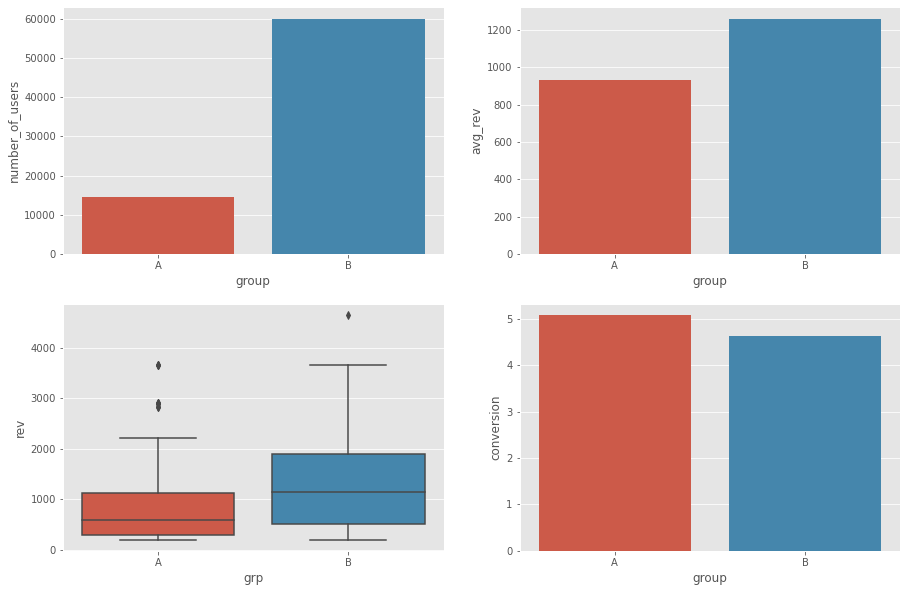

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.barplot(ax=axes[1, 1], x=metric_table.group, y=metric_table.conversion)
sns.barplot(ax=axes[0, 1], x=metric_table.group, y=metric_table.avg_rev)
sns.boxplot(ax=axes[1, 0], data=exp_active.query('paying == True'), x='grp', y='rev')
sns.barplot(ax=axes[0, 0], x=metric_table.group, y=metric_table.number_of_users)

## Задание 2. Python
## 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

### Напишем функцию для добавления информации из доп. файла

In [55]:
def add_new_data(
        exp_data,  # таблица с основными данными
        path_to_file,  # путь к файлу groups_add.csv
):
    df = pd.read_csv(path_to_file, sep=',')  # считываем датафрейм с дополнительными данными
    df.columns = ['id', 'grp']  # переименуем заголовок датафрема
    checks = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/84hTmELphW2sqQ', sep=';')
    # считываем данные о платежах
    active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/prbgU-rZpiXVYg', sep=';')
    # считываем данные об активных пользователях

    df = df.merge(active_studs, how='left', left_on='id', right_on='student_id')
    # примерджим данные об активных пользователях
    df['student_id'] = df.student_id.notna()
    df.rename(columns={'student_id': 'active'}, inplace=True)

    df = df.merge(checks, how='left', left_on='id', right_on='student_id')
    # примерджим данные об оплатах
    df['student_id'] = df.student_id.notna()
    df.rename(columns={'student_id': 'paying'}, inplace=True)
    df.rev.fillna(0, inplace=True)

    df = exp_data.append(df).drop_duplicates()  # добавим полученные датафрейм к существующему, уберем дубликаты
    k = df.shape[0] - experiment.shape[0]  # сравним значения до и после добавления датаврейма

    if k == 0:  # выведем сообщение в зависимости от того были ли добавлены новые данные
        print('Новых данных не обнаружено')
    else:
        print(f"Добавлено {k} новых строк")

    # расчитаем метрики на основании новых данных и выведем таблицу
    metric_table = df.groupby('grp', as_index=False).agg({'id': 'count', 'active': 'sum'})
    # вычислим количество пользователей и количество активных пользователей
    metric_table['paying_users'] = list(df.query('active == True').groupby('grp').paying.sum())
    # вычислим количество платящих пользователей
    metric_table['conversion'] = list(round(df.query('active == True').groupby('grp').paying.mean() * 100, 2))
    # вычислим конверсию
    metric_table['min_rev'] = list(round(experiment.query('paying == True and active == True')
                                                   .groupby('grp').rev.min(), 2))
    # вычислим минимальное значение чеков у активных платящих клиентов
    metric_table['max_rev'] = list(round(experiment.query('paying == True and active == True')
                                                   .groupby('grp').rev.max(), 2))
    # вычислим максимальное значение чеков у активных платящих клиентов
    metric_table['avg_rev'] = list(round(experiment.query('paying == True and active == True')
                                                   .groupby('grp').rev.mean(), 2))
    # вычислим среднее значение чеков у активных платящих клиентов
    metric_table.rename(columns={'grp': 'group', 'id': 'number_of_users', 'active': 'active_users'}, inplace=True)
    # назовем соответствующим образом колонки
    return metric_table

In [56]:
path = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/3aARY-P9pfaksg'

In [57]:
add_new_data(experiment, path)  # функция принимает на вход существущий датафрем и путь к group_add.csv

Новых данных не обнаружено


,group,number_of_users,active_users,paying_users,conversion,min_rev,max_rev,avg_rev
0,A,14693,1538,78,5.07,199.0,3660.0,933.59
1,B,59883,6803,314,4.62,199.0,4650.0,1257.88


### Напишем функцию для вывод графиков по заданным данным

In [58]:
def graphic(df):
    metric_table = df.groupby('grp', as_index=False).agg({'id': 'count', 'active': 'sum'})
    # вычислим количество пользователей и количество активных пользователей
    metric_table['paying_users'] = list(df.query('active == True').groupby('grp').paying.sum())
    # вычислим количество платящих пользователей
    metric_table['conversion'] = list(round(df.query('active == True').groupby('grp').paying.mean() * 100, 2))
    # вычислим конверсию
    metric_table['avg_rev'] = list(round(df.query('paying == True and active == True').groupby('grp').rev.mean(), 2))
    # вычислим среднее значение чеков у активных платящих клиентов
    metric_table.rename(columns={'grp': 'group', 'id': 'number_of_users', 'active': 'active_users'}, inplace=True)
    # назовем соответствующим образом колонки
    # настроим графики
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    sns.barplot(ax=axes[1, 1], x=metric_table.group, y=metric_table.conversion)
    sns.barplot(ax=axes[0, 1], x=metric_table.group, y=metric_table.avg_rev)
    sns.boxplot(ax=axes[1, 0], data=df.query('paying == True and active == True'), x='grp', y='rev')
    sns.barplot(ax=axes[0, 0], x=metric_table.group, y=metric_table.number_of_users)

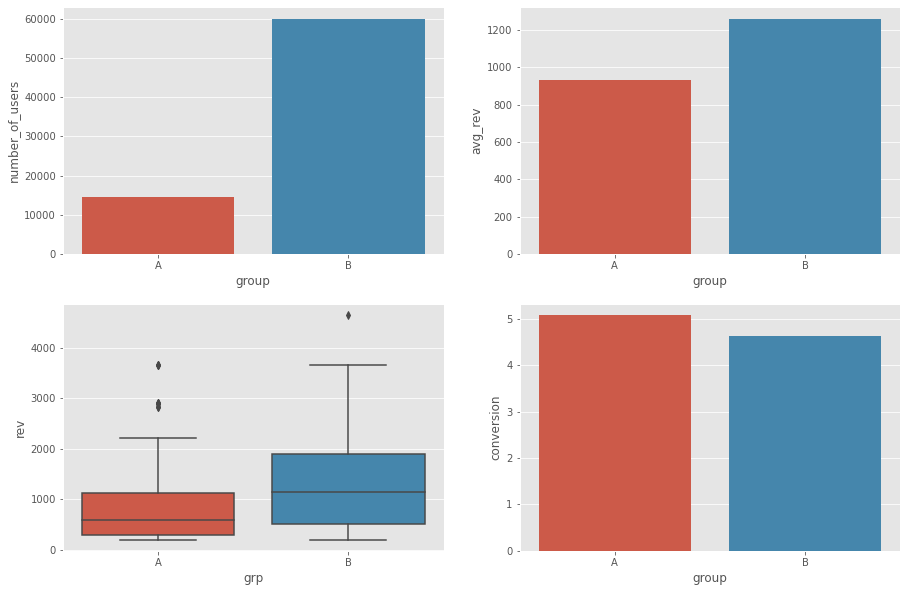

In [59]:
graphic(experiment)  # функция принимает на вход собранный датафрейм